# Laboratório 01 - fast.ai DL1 2019 Brasília


### Introdução

Bem vindos ao primeiro laboratório da turma fast.ai DL1 2019. O objetivo do laboratório é consolidar os conhecimentos obtidos nas aulas 01 e 02, bem como promover debate, discussões relacionadas ao tema, bem como fazer com que a maioria coloque a "mão na massa" como gosta nosso guru, Jeremy.

Realizaremos nesse laboratório o treinamento de uma rede neural para classificação de expressões faciais baseadas em fotos de pessoas. Utilizaremos a base de dados de um desafio do Kaggle de 2013, conforme detalhes mais adiante. O modelo treinado terá alcançado uma acurácia similiar, ou até superior, aos melhores modelos da competição em 2013. Além disso, vamos desenvolver um aplicativo web simples para colocar em produção nosso modelo treinado de a nos permitir testar novas imagens com expressões a avaliar a acurácia da rede neural na prática.

Esse notebook é uma combinação de dois posts do colega [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/), que cedeu seu código para que possamos consolidar nossos conhecimentos:

- [Face Expression Recognition with fastai v1](https://medium.com/@pierre_guillou/face-expression-recognition-with-fastai-v1-dc4cf6b141a3).
- [Deep Learning Web App by fastai v1](https://medium.com/@pierre_guillou/deep-learning-web-app-by-fastai-v1-3ab4c20b7cac)


### Reconhecimento de Expressões Faciais (Face Expression Recognition Kaggle Challenge - FER 2013) com fastai v1

by: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/) (novembro 2018)  
    [Leon Silva](https://www.linkedin.com/in/leonsolon/) (tradução/atualização março 2019)
    [Vinícius Ramos](https://www.linkedin.com/in/vinicius-ramos-6a367073/) (atualização/deploy no Django na GCP março 2018)

- Inspirado por [Recognizing Facial Expressions Using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/224.pdf) (2017) of Alexandru Savoiu and James Wong (Stanford University)
- Base de dados : [FER 2013 Kaggle Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/)
- Deep Learning utilizando [fastai v1](https://www.fast.ai/2018/10/02/fastai-ai/)

# Inicialização

Vamos começar como todo e qualquer notebook que utiliza fast.ai

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

# Configuração da API Kaggle

Faremos o download do banco de imagens diretamente do Kaggle. Para tal, é necessário seguir os passos abaixo. Este notebook está focalizado na google cloud platform (GCP), tendo em vista que a maioria da turma realizou essa instalação. Se você está lendo isso é porque já está rodando o jupyter de alguma forma, seja na máquina local, seja no gcp, portanto, pularemos os passos de inicialização da instância e do jupyter.

1. Caso ainda não possua, cria sua conta no [Kaggle](https://www.kaggle.com) no seu computador local
2. No canto superior direito, clique na sua foto (ou avatar) e selecione 'My account'
3. Selecione a opção 'Create API Token'. 
4. Ao selecionar a opção será baixado um arquivo na sua máquina, chamada `kaggle.json`. Esse arquivo contém as credenciais da API do Kaggle (nome de usuário e senha)
5. Abra o arquivo `kaggle.json` no seu editor de textos preferido e copie o conteúdo. Cole o conteúdo na célula abaixo, no local indicado.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder = 'kaggle'

In [0]:


path = Path(base_dir)
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [28]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/kaggle')]

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Comando que cria a pasta Kaggle em /home/<seu_usuario>. Essa pasta é necessária para conter a chave de API do Kaggle
!rm -rf ~/.kaggle
!mkdir ~/.kaggle

# Esse comando cria o arquivo kaggle.json na instância no local correto: /home/<seu_usuario/.kaggle/kaggle.json
!echo 'conteudo do kaggle.json' >> ~/.kaggle/kaggle.json

# Por questões de segurança, garanta que outros usuários do seu computador não tenham acesso de leitura 
# às suas credenciais. Esse comando é necessário, do contrário a API do Kaggle se recusa a fazer o download das bases de dados.
!chmod 600 ~/.kaggle/kaggle.json

In [24]:
# Com a chave de API do Kaggle, agora é a vez de instalar a API do kaggle
!sudo pip install kaggle

### Termos da competição

Um passo importante, antes de baixar os dados do Kaggle, é aceitar os termos da competição. Para isso, acesse a seção `rules` na [página da competição](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/rules) e clique em `I Understand and Accept`

# Dados

## Download do Kaggle

Agora que temos a conta, chave de API e pacote instalado, basta realizarmos o download das imagens com as expressões faciais direto do kaggle. 

In [27]:
# Comando para alterar pasta para '~/.fastai/data', onde os arquivos serão armazenados. 
%cd ~/.fastai-v3/data

# Finalmente, download do arquivo FER 2013 a partir da conta do Kaggle (fer2013.tar.gz)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

[Errno 2] No such file or directory: '/root/.fastai-v3/data'
/root/.fastai/data
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle

In [0]:
# Use os comandos abaixo para criar uma pasta para FER (face expression recognition)
# e para descompactar o arquivo dentro da pasta FER
!mkdir FER
!mv fer2013.tar.gz FER
!rm example_submission.csv
!tar -xvf FER/fer2013.tar.gz -C FER

## Listando arquivos

In [30]:
# Verificar se os arquivos foram descompactados corretamente
%cd /content/gdrive/My Drive/fastai-v3/data
# %cd ~/.fastai/data/
PATH = Path('./FER/fer2013')
PATH.ls()

/content/gdrive/My Drive/fastai-v3/data


[PosixPath('FER/fer2013/fer2013.bib'),
 PosixPath('FER/fer2013/README'),
 PosixPath('FER/fer2013/fer2013.csv')]

In [31]:
# Nessa competição, as imagens foram armazenadas em forma de pixels, com os valores RGB de cada
# A 1a coluna apresenta a emoção (expressão) a qual a imagem representa
# A 2a coluna apresenta a imagem em si, num arranjo de números RFB que representa os pixels
# A 3a coluna traz a utilidade da imagem, se será utilizada para treinamento, teste público ou teste privado (detalhes mais adiante).
df = pd.read_csv(PATH/'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [32]:
# As expressões das imagens na descrição do desafio do Kaggle, de 0 a 6 são
# Raiva, Nojo, Medo, Alegria, Tristeza, Surpresa, Neutro
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [33]:
# Também temos a utilização das imagens, treinamento, teste público e teste privado 
# Os desafios Kaggle possuem um teste público, com a base que disponibilizam para criação dos modelos
# e uma privada que somente é testada com a submissão dos resultados
usages = df['Usage'].unique();usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [34]:
# Vamos separar os data frames em treinamento, teste público e teste privado
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# Os tamanhos de cada data frame
n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


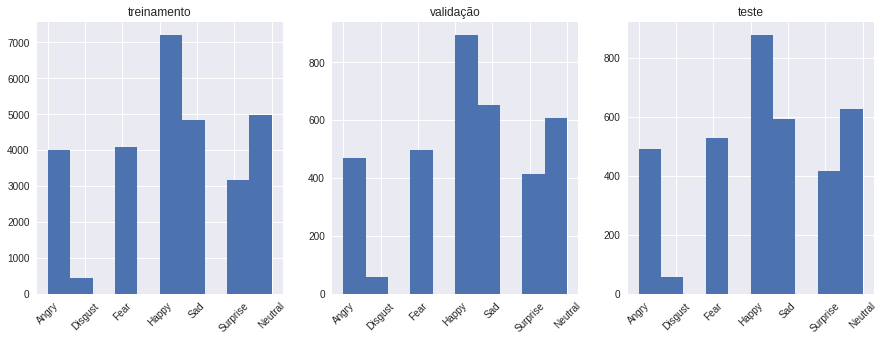

In [35]:
# histograma das bases de treinamento, teste público e teste privado
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'treinamento')
setup_axe(axes[1],df_valid,'validação')
setup_axe(axes[2],df_test,'teste')
plt.show()

In [36]:
# Vamos avaliar a proporção das imagens na base de treinamento de cada uma das 7 expressões
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


In [0]:
# A função abaixo recria a imagem a partir dos pixels. Lembrando que as imagens são sequências de 3 números para cada pixel, ex (48,48,3)
# Vamos representar a expressão como um inteiro e os pixels de uma imagem como um array numpy 
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# Apresenta imagem já convertida com o título da expressão
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

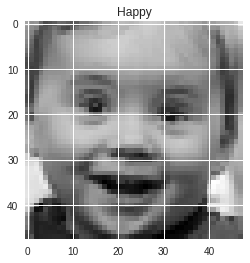

In [38]:
# Vamos dar uma olhada na base para ver as imagens? Brinquem à vontade, aqui não somos Gilberto Gil, mas vamos de 2222
row = df_train.iloc[2222]
img = row2image(row)
show(img)

# Armazenar os dados (pixels) em forma de imagens nas pastas train/val/test

In [0]:
# Com a função de pixels (com 3 números cada) para arquivos, vamos agora criar as pastas para armazenar cria as pastas train, valid e test
Path(PATH/'train').mkdir(exist_ok=True)
Path(PATH/'valid').mkdir(exist_ok=True)
Path(PATH/'test').mkdir(exist_ok=True)

In [0]:
# Define as variáveis das pastas de treinamento, teste público e teste privado
PATH_train = PATH/'train'
PATH_valid = PATH/'valid'
PATH_test = PATH/'test'

In [0]:
# cria as 7 pastas das expressões em cada uma das pastas train, train, val e test
for l in labels:
    Path(PATH_train/l).mkdir(exist_ok=True)
    Path(PATH_valid/l).mkdir(exist_ok=True)
    Path(PATH_test/l).mkdir(exist_ok=True)

In [0]:
# Cria as imagens a partir dos pixels e salva nas subpastas correspondentes. Aqui utilizaremos o teste público como validação
# e teste privado como teste
def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path/labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = PIL.Image.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e/fname)
            i += 1

In [0]:
# Cria as imagens e posiciona nas subpastas
createImages(df_train,PATH_train)
createImages(df_valid,PATH_valid)
createImages(df_test,PATH_test)

In [44]:
# Vamos dar uma olhada se a criação ocorreu da forma desejada
p = PATH_train/'Angry'
p.ls()[:5]

[PosixPath('FER/fer2013/train/Angry/0_0.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_1.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_3.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_4.jpg')]

# Criar o ImageDataBunch parametrizado para resnet50

In [0]:
# Cria transformações para as imagens como forma de aumentar as informações do dataset (data augmentation)
tfms = get_transforms()

In [46]:
# ImageDataBunch
# bs=16, size=299 : ajustamos os parametros para o laboratório terminar num tempo razoável, mas o melhor seria o valor 
# do hiperparâmetro size=299 para ajudar à resnet50
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=16, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: FER/fer2013;

Test: None

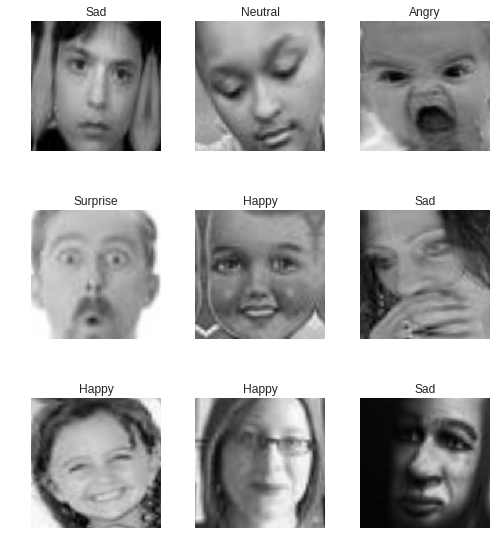

In [47]:
data.show_batch(rows=3, figsize=(7,8))

In [48]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

# Treinar o modelo com transfer learning (resnet50)

In [49]:
# cria o learner a partir do resnet50 com métrica de acurácia para buscar dos coeficientes da rede neural
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 92013195.31it/s]


In [50]:
# one cycle training com 4 épocas
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.546878,1.420372,0.459738,08:57
1,1.275305,1.196340,0.547785,08:48
2,1.154018,1.120431,0.566174,08:47
3,1.163142,1.105300,0.581220,08:43


In [0]:
# salvando o estágio atual (caso o preemptive resolve nos ajudar O.o)
learn.save('fer2013-stage-1')

In [52]:
learn.load('fer2013-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
# Com o modelo treinado somente com as novas imagens, vamos "descongelar" o learner para reaprender com o resnet50 completo
learn.unfreeze()

In [54]:
# buscar os melhores learning rates
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


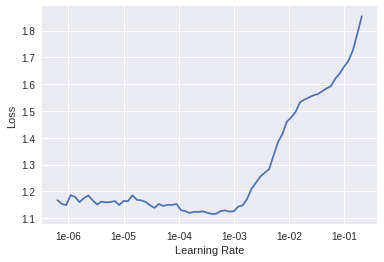

In [55]:
learn.recorder.plot()

In [0]:
# com base no gráfico vamos retreinar com 6 épocas e learning rates específicos
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
# salvar estágio atual
learn.save('fer2013-stage-2')

# exportar o modelo treinado. Importante para implantarmos no nosso aplicativo web!
learn.export('modelo.pkl')

# Resultados

Com o modelo treinado, vamos avaliar os resultados, principalmente com relação a acurácia.

In [0]:
learn.load('fer2013-stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
# A matriz de confusão mostra que, para as expressões com mais dados para treinamento temos um acerto maior
interp.plot_confusion_matrix()

In [0]:
# Avaliando quais foram as piores classificações em termos de erro
interp.plot_top_losses(9, figsize=(15,11))

# Acurácia

In [0]:
val_probs, val_targets = learn.get_preds()

In [0]:
val_preds = torch.argmax(val_probs,1)

In [0]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

Apesar de parecer pouco, um modelo com 64% de acurácia estaria bem colocado no desafio do Kaggle, isso sem muito esforço, pois poderíamos melhorar o tamanho da imagem e realizar limpeza das imagens expúreas/dúbias.


# Utilizando o modelo em produção (predição de novas fotos)

Agora vamos testar nosso modelo com aquelas imagens que não foram utilizadas nem no treino nem na validação. Brinquem à vontade, alterando a pasta de 'Happy' para outras expressões, bem como o índice do array de arquivos.

In [0]:
data.classes

In [0]:
# get image from test folder (images arquived in subfolders)
p = PATH_test/'Happy'
url = p.ls()[1]
img = open_image(url)
img

In [0]:
# get prediction
#probs = learn.predict(img)
#prediction = learn.data.classes[probs.argmax()]
#prediction

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

## Buscando imagem da internet

Vamos tentar buscar uma imagem na internet e realizar uma classificação da expressão facial? 

In [0]:
# Download da imagem
!wget http://thesharpe.com/wp-content/uploads/2017/01/surprise-someone-1-1024x768.jpg
    
# Transformação para grayscale (as imagens treinadas e validadas também estão em grayscale)
img = PIL.Image.open('surprise-someone-1-1024x768.jpg').convert('LA')

# Salvar a imagem (percebam que o formato deve ser png)
img.save('surprise-someone-1-1024x768.png')    
    
# Mudança de semântica! Antes img era uma imagem do pacote PIL, agora é uma imagem fast.ai (open_image)    
img = open_image('./surprise-someone-1-1024x768.png')

# Vamos dar uma olhada na imagem baixada em grayscale
img

In [0]:
# Vamos realizar as transformações utilizadas nas imagens de treino? A imagem a ser classificada será reduzida e poderá
# sofrer algumas rotações e distorções
tfms = get_transforms()

for transformation in tfms:
    img = img.apply_tfms(transformation, size=224)

img

In [0]:
# finalmente, vamos prever o que o Kevin McCallister estava expressando
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

# Como disponibilizar seu modelo na internet

Agora que temos um modelo treinado, funcionando razoavelmente bem, que tal criarmos uma aplicação web que recebe fotos e classifica a expressão do rosto?

O colega Vinícius Ramos subiu no github uma [aplicação](https://github.com/viniciusramos91/ai-web-app.git) pronta para realizarmos o deploy do modelo treinado na própria instância do GCP: uma mão na roda :)

Vamos aproveitar a aplicação aqui para utilizar o nosso modelo exportado. Devemos clonar o projeto para buscar os arquivos necessários para nossa web app.

Para tal, utilizaremos o Django, um _framework_ web robusto escrito em Python, para fazer o _deploy_ do seu modelo. Dessa forma, qualquer um poderá acessar sua aplicação e testá-la.

## Um pouco sobre Django...

Django é um framework de alto nível, escrito em Python que encoraja o desenvolvimento limpo de aplicações web.

Desenvolvido por experientes desenvolvedores, Django toma conta da parte pesada do desenvolvimento web, como: 
- Tratamento de requisições
- Mapeamento objeto-relacional
- Preparação de respostas HTTP
- Autenticação
- Autorização; e muito mais

Dessa forma, você gasta seu esforço com aquilo que realmente interessa: suas **regras de negócio**!

Foi desenvolvido com uma preocupação extra em segurança, evitando os mais comuns ataques, como _Cross Site Scripting_ (XSS), _Cross Site Request Forgery_ (CSRF), _SQL injection_, entre outros.

É bastante **escalável**: Django foi desenvolvido para tirar vantagem da maior quantidade de hardware possível (desde que você queira). Django usa uma arquitetura “zero-compartilhamento”, o que significa que você pode adicionar mais recursos em qualquer nível: servidores de banco de dados, cache e/ou servidores de aplicação.

### Sua arquitetura

Diferente da arquitetura de outros _frameworks_ web que seguem o padrão MVC (_Model-View-Controller_), o Django possui uma arquitetura sutilmente diferente: seus desenvolvedores o denominaram de **MTV** ou _**Model-Template-View**_.

As responsabilidades de cada camada são:
- _**Model**_: Faz o mapeamento dos objetos da sua aplicação com tabelas relacionais e gerencia as transações que acessam o banco de dados.
- _**Template**_: Contém a camada de apresentação da sua aplicação (arquivos HTML, arquivos de estilo CSS, possíveis bibliotecas Javascript e etc). É a **cara** do seu projeto.
- _**View**_: Essa camada tem a responsabilidade de processar as requisições vindas dos usuários, formular uma resposta e enviá-la. É aqui que residem nossas **lógicas de negócio**.

### Fluxo de uma requisição

O fluxo de uma Requisição HTTP dentro do Django pode ser demonstrado da seguinte forma:

![Fluxo de uma requisição](https://raw.githubusercontent.com/viniciusramos91/ai-web-app/master/notebook/django-architecture.png)
_Fonte: [Python Academy](https://pythonacademy.com.br/blog/desenvolvimento-web-com-python-e-django-introducao)_

Agora que você já sabe (quase) tudo sobre o Django, vamos para a **prática**

### Primeiros passos

Se você estiver utilizando a Google Cloud Platform, abra uma nova janela de terminal (_Open in browser window_):

![Google Cloud Platform](https://raw.githubusercontent.com/viniciusramos91/ai-web-app/master/notebook/gcp.png)

Agora, clone o projeto Django:

In [0]:
# Esses passos podem ser executados no próprio notebook ou no terminal SSH
# Vá para pasta home
%cd ~

# Clone o projeto
!git clone https://github.com/viniciusramos91/ai-web-app.git
    
# Vá para dentro do projeto
%cd ./ai-web-app

# Copei o modelo treinado para a pasta correta
%mkdir /home/jupyter/playground
%cp ~/.fastai/data/FER/fer2013/modelo.pkl /home/jupyter/playground

Agora, instale as dependências do projeto (no caso apenas o Django), executando a célula abaixo:

In [0]:
!pip install -r requirements.txt --user

A estrutura do projeto é:

```
requirements.txt
manage.py
webapp/
    > settings.py
    > urls.py
    > wsgi.py
```

Explicando cada arquivo:

- `requirements.txt`: Arquivo de dependências de projetos Python.
- `manage.py`: Arquivo gerado automaticamente pelo Django que expõe comandos importantes para manutenção da nossa aplicação.
- `webapp/settings.py`: Arquivo muito importante com as configurações do nosso projeto, como configurações do banco de dados, aplicativos instalados, configuração de arquivos estáticos e muito mais.
- `webapp/urls.py`: Nossa URLConf - aqui vamos dizer ao Django quem responde a qual URL.
- `webapp/wsgi.py``: Aqui configuramos a interface entre o servidor de aplicação e nossa aplicação Django.

Com a estrutura acima criada, é necessário fazer a carga inicial do banco de dados do Django. 

Para isso, executaremos o comando `migrate` do Django conforme a célula abaixo (deverá ser criado o banco de dados `db.sqlite3` na raíz do projeto).

In [0]:
!python manage.py migrate

Agora, execute o comando abaixo e abra seu browser e acesse sua instância na porta 8000 com seu IP externo. 

Para **parar** sua execução, clique no botão de _Stop_ (barra de ferramentas do Jupyter - ao lado do _Run_).

In [0]:
!python manage.py runserver 0.0.0.0:8000

A tela inicial do projeto deverá ser mostrada:

![Django default](https://raw.githubusercontent.com/viniciusramos91/ai-web-app/master/notebook/index.png)

E ao fazer o upload de uma imagem, a seguinte tela será exibida:

![Resultado](https://raw.githubusercontent.com/viniciusramos91/ai-web-app/master/notebook/result.png)

**Obs**: Ainda não estárá funcionando pois seu modelo não foi configurado.

### Entendendo um pouco do projeto Django

Com o objetivo de criar uma página gerenciada pelo Django, é necessário fazermos, basicamente, três passos:
- Criar a página html que será mostrada ao usuário.
- Escrever a lógica no arquivo `views.py` (ainda não criado).
- Adicionar a rota no arquivo `urls.py` .

### Arquivo `index.html`

O arquivo `webapp/templates/webapp/index.html` contém o código HTML da nossa página inicial. 

Ela é responsável por fazer o _upload_ de uma foto ao Django.

Sem muito mistério aqui...

### Arquivo `views.py`

No Django, o código responsável por processar a requisição do usuário e retornar uma resposta reside em uma `View`.

No nosso caso, nossa `View`:
- Recebe uma imagem
- Trata a imagem
- Carrega nosso modelo
- Faz o `predict` utilizando a imagem tratada
- Retorna a classe daquela imagem

Para que seu modelo seja executado, altere o arquivo `webapp/views.py`, onde se encontra o seguinte trecho de código:

```python
learn = load_learner('/home/jupyter/playground', fname='modelo.pkl')
```

_(Aponte para o arquivo do seu modelo)_

O código da nossa `View` é o seguinte (siga os comentários):

```python
from django.shortcuts import render
from fastai import *
from fastai.vision import *
from django.http import HttpRequest, HttpResponse
from io import BytesIO

# View da página principal
# =======================================================================

def index(request: HttpRequest) -> HttpResponse:

    # Verifica o método HTTP
    if request.method == 'GET':
        # Se GET, renderiza a página HTML
        return render(request, 'webapp/index.html', status=200)
    
    # Se POST
    elif request.method == 'POST':
        # Pega a image da requisição
        image = request.FILES['image']

        # Lê os bytes da imagem
        data = BytesIO(image.read())

        # Chama o PIL para converter a imagem em preto e branco
        img = PIL.Image.open(data).convert('LA')

        # Salva a imagem em disco
        img.save('imagem.png')

        # Abre a imagem com o fast.ai
        img = open_image('imagem.png')

        # Carrega o conjunto padrão de transformações do fast.ai para aplicar na imagem
        tfms = get_transforms()

        # Aplica as transofmrações na imagem
        for transformation in tfms:
            fastai_img = img.apply_tfms(transformation, size=224)

        # Carrega o modelo
        learn = load_learner('/home/jupyter/playground', fname='modelo.pkl')

        # Executa o modelo sobre a imagem
        pred_class, pred_idx, outputs = learn.predict(fastai_img)

        return HttpResponse(pred_class, status=200)

    else:
        return HttpResponse('Método não permitido', status=405)
```     

### Arquivo `urls.py`

Para que o Django chame nossa `View` é necessário que sua rota esteja configurada corretamente.

Isso é feito no arquivo `webapp/urls.py`. Veja como é simples (siga os comentários):

```python
from django.contrib import admin
from django.urls import path
from webapp.views import index

# Lista contendo todos os caminhos da sua aplicação
urlpatterns = [
    # Sim, o Django já vem com uma área de administrador por padrão!
    # Acesse: https://docs.djangoproject.com/en/2.0/intro/tutorial02/#introducing-the-django-admin
    path('admin/', admin.site.urls),
    
    # Rota que encaminha as requisições do caminho raíz para nossa view index()
    path('', index)
]
```